# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [5]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

In [6]:
#criando um dataframe para analise dos dados
analise=pd.DataFrame({'colunas': fifa.columns,
                     'tipos': fifa.dtypes,
                     'missing': fifa.isna().sum(),
                      'size': fifa.shape[0],
                     'unicos': fifa.nunique()})
analise['percentual']=analise['missing']/analise['size']
analise

,colunas,tipos,missing,size,unicos,percentual
Age,Age,int64,0,18207,29,0.000000
Overall,Overall,int64,0,18207,48,0.000000
Potential,Potential,int64,0,18207,47,0.000000
Crossing,Crossing,float64,48,18207,89,0.002636
Finishing,Finishing,float64,48,18207,93,0.002636
HeadingAccuracy,HeadingAccuracy,float64,48,18207,91,0.002636
ShortPassing,ShortPassing,float64,48,18207,85,0.002636
Volleys,Volleys,float64,48,18207,87,0.002636
Dribbling,Dribbling,float64,48,18207,94,0.002636
Curve,Curve,float64,48,18207,89,0.002636


In [7]:
fifa.dropna(inplace=True)

Text(0.5, 1, 'Correlation between different fearures')

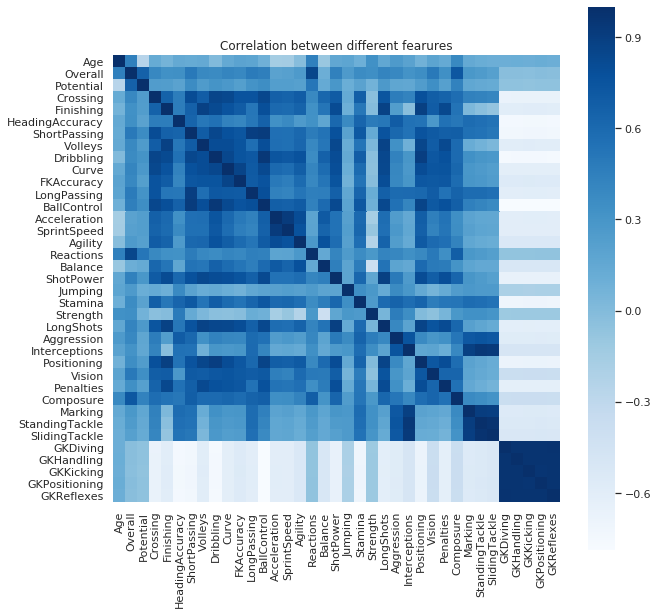

In [8]:
correlation = fifa.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=False,cmap='Blues')

plt.title('Correlation between different fearures')

## Inicia sua análise a partir daqui

In [9]:
# Sua análise começa aqui.
fifa.head()
pca = PCA(n_components=1)
pca.fit_transform(fifa.dropna())
pca.explained_variance_ratio_

ratio1 = pca.explained_variance_ratio_
print(round(float(ratio1),3))

pca = PCA(0.95)
pca.fit_transform(fifa.dropna())
n_components = pca.n_components_

#PCA.fit(fifa)

x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]
pca = PCA()
pca.fit_transform(fifa.dropna())
resp3 = (x * pca.singular_values_)[:3]
tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, resp3))



0.565


(8808.714, -7100.578, -4297.299)

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


y_train = fifa['Overall']
X_train = fifa.drop(columns = 'Overall')

reg = LinearRegression()

selector = RFE(reg, n_features_to_select=5, step=1)
selector = selector.fit(X_train,y_train)
features=pd.DataFrame({'coluna':X_train.columns,
              'bool': selector.get_support()})
features


,coluna,bool
0,Age,True
1,Potential,True
2,Crossing,False
3,Finishing,False
4,HeadingAccuracy,False
5,ShortPassing,False
6,Volleys,False
7,Dribbling,False
8,Curve,False
9,FKAccuracy,False


In [12]:
list(features[features['bool'] == True]['coluna'])

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [13]:
def q1():
    # Retorne aqui o resultado da questão 1.
    pca = PCA(n_components=1)
    pca.fit_transform(fifa.dropna())
    ratio1 = pca.explained_variance_ratio_
    return round(float(ratio1),3)

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [14]:
def q2():
    # Retorne aqui o resultado da questão 2.
    pca = PCA(0.95)
    pca.fit_transform(fifa.dropna())
    n_components = pca.n_components_
    return int(n_components)

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [15]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [24]:
def q3():
    # Retorne aqui o resultado da questão 3.
    pca = PCA()
    pca.fit_transform(fifa)
    resp3 = (pca.components_.dot(x))[:2]
    
    return tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, resp3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [17]:
def q4():
    # Retorne aqui o resultado da questão 4.
    return list(features[features['bool'] == True]['coluna'])

In [18]:
q1()

0.565

In [19]:
q2()

15

In [25]:
q3()

(186.556, -6.592)

In [21]:
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']